# train doc2vec

## import data

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import jieba
import re
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument

In [2]:
df = pd.read_csv('./data/merged.csv')
df = df[['Singer', 'Name', 'Lyric', 'Category']].astype(str)
df.drop(df[df.Singer == 'nan'].index, inplace=True)
df.drop(df[df.Name == 'Name'].index, inplace=True)
print("\033[32mTotal number of data: %d\033[0m" %len(df))

Total number of data: 2206


In [3]:
d = {'Category': df['Category'].value_counts().index, 'count': df['Category'].value_counts()}
df_cat = pd.DataFrame(data = d).reset_index(drop = True)
print(df_cat)

   Category  count
0        愛情    874
1      想法表達    405
2        悲傷    216
3    反抗反駁反諷    206
4        勵志    167
5        嗨歌    125
6        離別     76
7        友情     42
8      特殊主題     39
9        親情     33
10       感謝     23


In [4]:
df.loc[df.Category == '勵志','Category'] = '勵志友情'
df.loc[df.Category == '友情','Category'] = '勵志友情'
df.loc[df.Category == '悲傷','Category'] = '悲傷離別'
df.loc[df.Category == '離別','Category'] = '悲傷離別'
df.loc[df.Category == '特殊主題','Category'] = '其他'
df.loc[df.Category == '嗨歌','Category'] = '其他'
df.loc[df.Category == '親情','Category'] = '其他'
df.loc[df.Category == '感謝','Category'] = '想法表達'

In [5]:
d = {'Category': df['Category'].value_counts().index, 'count': df['Category'].value_counts()}
df_cat = pd.DataFrame(data = d).reset_index(drop = True)
df_cat

,Category,count
0,愛情,874
1,想法表達,428
2,悲傷離別,292
3,勵志友情,209
4,反抗反駁反諷,206
5,其他,197


In [6]:
condition = df['Category'] == '愛情'
df_select = df[condition].sample(300)
condition = df['Category'] == '想法表達'
df_tmp = df[condition].sample(300)
df_select = pd.concat([df_select, df_tmp])
condition = df['Category'] == '勵志友情'
df_tmp = df[condition].sample(0)
df_select = pd.concat([df_select, df_tmp])
condition = df['Category'] == '悲傷離別'
df_tmp = df[condition].sample(292)
df_select = pd.concat([df_select, df_tmp])
condition = df['Category'] == '反抗反駁反諷'
df_tmp = df[condition].sample(0)
df_select = pd.concat([df_select, df_tmp])

df_select = df_select.reset_index(drop=True)

In [7]:
categories = list(df_select['Category'].value_counts().index)

In [8]:
d = {'Category': df_select['Category'].value_counts().index, 'count': df_select['Category'].value_counts()}
df_cat = pd.DataFrame(data = d).reset_index(drop = True)
df_cat

,Category,count
0,愛情,300
1,想法表達,300
2,悲傷離別,292


## 資料預處理

### 清理 + 斷詞

In [9]:
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    re_han = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = re_han.sub('', line)
    return line

In [10]:
cat_to_id = dict(zip(categories, range(len(categories))))
def label_to_id(line):
    line = str(line)
    return cat_to_id[line]

In [11]:
categories

['愛情', '想法表達', '悲傷離別']

In [12]:
df_select['y'] = df_select['Category'].apply(label_to_id)
stopwords = [line.strip() for line in open('./data/stopwords.txt', 'r', encoding='utf-8').readlines()]
df_select['clean_text'] = df_select['Lyric'].apply(remove_punctuation)
df_select['seg_text'] = df_select['clean_text'].apply(lambda x: [w for w in list(jieba.cut(x)) if w not in stopwords])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.827 seconds.
Prefix dict has been built successfully.


In [13]:
df_select

,Singer,Name,Lyric,Category,y,clean_text,seg_text
0,蘇打綠,朱古力,加點糖分 再加點顏色 漸漸沖淡原來美味的苦澀包裝陪襯 再包裝快樂 漸漸磨損原來無邪的興奮真實...,愛情,0,加點糖分再加點顏色漸漸沖淡原來美味的苦澀包裝陪襯再包裝快樂漸漸磨損原來無邪的興奮真實總是需要...,"[加點, 糖分, 再, 加點, 顏色, 漸漸, 沖, 淡, 原來, 美味, 苦澀, 包裝, ..."
1,梁靜茹,我不害怕,你有多瞭解 我的每一天 心情都是怎麼交接夜裡回家 容不容易找到車位我多想知道 在你的世界 什...,愛情,0,你有多瞭解我的每一天心情都是怎麼交接夜裡回家容不容易找到車位我多想知道在你的世界什麼你會放最...,"[瞭解, 一天, 心情, 交接, 夜裡, 回家, 容, 容易, 找到, 車位, 想, 知道,..."
2,陳奕迅,月球上的人,無須要快樂 反正你一早枯死如果有眼淚 只不過生理分泌就算淚水多得 可灌溉整片濕地蒲公英不會飛...,愛情,0,無須要快樂反正你一早枯死如果有眼淚只不過生理分泌就算淚水多得可灌溉整片濕地蒲公英不會飛陵墓裡...,"[無須, 快樂, 反正, 一早, 枯死, 眼淚, 只, 生理, 分泌, 淚水多, 灌溉, 整..."
3,蘇打綠,融雪之前,某夜 你離開 某天 你走來某刻 我明白 某種 我的愛睡在 夢境徘徊 世界停擺 只剩我存在看見...,愛情,0,某夜你離開某天你走來某刻我明白某種我的愛睡在夢境徘徊世界停擺只剩我存在看見風吹來聽見雲散開預...,"[某夜, 離開, 某天, 走, 某刻, 明白, 某種, 愛睡, 夢境, 徘徊, 世界, 停,..."
4,楊丞琳,你是壞人,你給的愛 像顆甜蜜的糖果我好想咬一口卻又害怕牙齒痛痛你給的愛 像巧克力的誘惑甜的熱量對健康小...,愛情,0,你給的愛像顆甜蜜的糖果我好想咬一口卻又害怕牙齒痛痛你給的愛像巧克力的誘惑甜的熱量對健康小心負...,"[你給, 愛像顆, 甜蜜, 糖果, 好, 想, 咬一口, 卻, 害怕, 牙齒, 痛痛, 你給..."
...,...,...,...,...,...,...,...
887,SHE,說你愛我,下著雨讓濕氣稀釋回憶 我靠著你不出聲音看著你看著斑駁的甜蜜 愛你困住你也困住我自己我那躲也躲...,悲傷離別,2,下著雨讓濕氣稀釋回憶我靠著你不出聲音看著你看著斑駁的甜蜜愛你困住你也困住我自己我那躲也躲不掉...,"[下著雨, 濕氣, 稀釋, 回憶, 不出, 聲音, 斑駁, 甜蜜, 愛你, 困住, 困住, ..."
888,蔡依林,假面的告白,好像缺(碎)了一塊 再拼(補)不回來 再不存在 比空白更空白 每一次我想起來 其實你都還在 ...,悲傷離別,2,好像缺碎了一塊再拼補不回來再不存在比空白更空白每一次我想起來其實你都還在藍色悲哀流過我的靜脈...,"[好像, 缺碎, 一塊, 再, 拼補, 回來, 再, 存在, 空白, 空白, 一次, 想起,..."
889,SHE,不說再見,你好嗎 找到你的幸福了嗎那笑容 一樣像花燦爛嗎曾經一起闖 不怕風雨有多狂驕傲 沮喪 還刻在我...,悲傷離別,2,你好嗎找到你的幸福了嗎那笑容一樣像花燦爛嗎曾經一起闖不怕風雨有多狂驕傲沮喪還刻在我心上我很好...,"[你好, 找到, 幸福, 笑容, 花燦爛, 曾經, 一起, 闖, 風雨有, 多狂, 驕傲, ..."
890,SHE,不作你的朋友,慢慢失憶 所有和你的事情必須忘記愛的盆地 深怕再一滴眼淚就會決堤我也不想被你肯定 在這個時候...,悲傷離別,2,慢慢失憶所有和你的事情必須忘記愛的盆地深怕再一滴眼淚就會決堤我也不想被你肯定在這個時候說我讓...,"[慢慢, 失憶, 所有, 事情, 忘, 記愛的, 盆地, 深怕, 再, 一滴, 眼淚, 決堤..."


### shuffle

In [14]:
from sklearn.utils import shuffle

np.random.seed(1234)

X, y = shuffle(df_select['seg_text'], df_select['y'])

X.reset_index(drop = True, inplace = True)
y.reset_index(drop = True, inplace = True)

## 訓練Doc2Vec

### initialize

In [15]:
df = df_select

In [16]:
df

,Singer,Name,Lyric,Category,y,clean_text,seg_text
0,蘇打綠,朱古力,加點糖分 再加點顏色 漸漸沖淡原來美味的苦澀包裝陪襯 再包裝快樂 漸漸磨損原來無邪的興奮真實...,愛情,0,加點糖分再加點顏色漸漸沖淡原來美味的苦澀包裝陪襯再包裝快樂漸漸磨損原來無邪的興奮真實總是需要...,"[加點, 糖分, 再, 加點, 顏色, 漸漸, 沖, 淡, 原來, 美味, 苦澀, 包裝, ..."
1,梁靜茹,我不害怕,你有多瞭解 我的每一天 心情都是怎麼交接夜裡回家 容不容易找到車位我多想知道 在你的世界 什...,愛情,0,你有多瞭解我的每一天心情都是怎麼交接夜裡回家容不容易找到車位我多想知道在你的世界什麼你會放最...,"[瞭解, 一天, 心情, 交接, 夜裡, 回家, 容, 容易, 找到, 車位, 想, 知道,..."
2,陳奕迅,月球上的人,無須要快樂 反正你一早枯死如果有眼淚 只不過生理分泌就算淚水多得 可灌溉整片濕地蒲公英不會飛...,愛情,0,無須要快樂反正你一早枯死如果有眼淚只不過生理分泌就算淚水多得可灌溉整片濕地蒲公英不會飛陵墓裡...,"[無須, 快樂, 反正, 一早, 枯死, 眼淚, 只, 生理, 分泌, 淚水多, 灌溉, 整..."
3,蘇打綠,融雪之前,某夜 你離開 某天 你走來某刻 我明白 某種 我的愛睡在 夢境徘徊 世界停擺 只剩我存在看見...,愛情,0,某夜你離開某天你走來某刻我明白某種我的愛睡在夢境徘徊世界停擺只剩我存在看見風吹來聽見雲散開預...,"[某夜, 離開, 某天, 走, 某刻, 明白, 某種, 愛睡, 夢境, 徘徊, 世界, 停,..."
4,楊丞琳,你是壞人,你給的愛 像顆甜蜜的糖果我好想咬一口卻又害怕牙齒痛痛你給的愛 像巧克力的誘惑甜的熱量對健康小...,愛情,0,你給的愛像顆甜蜜的糖果我好想咬一口卻又害怕牙齒痛痛你給的愛像巧克力的誘惑甜的熱量對健康小心負...,"[你給, 愛像顆, 甜蜜, 糖果, 好, 想, 咬一口, 卻, 害怕, 牙齒, 痛痛, 你給..."
...,...,...,...,...,...,...,...
887,SHE,說你愛我,下著雨讓濕氣稀釋回憶 我靠著你不出聲音看著你看著斑駁的甜蜜 愛你困住你也困住我自己我那躲也躲...,悲傷離別,2,下著雨讓濕氣稀釋回憶我靠著你不出聲音看著你看著斑駁的甜蜜愛你困住你也困住我自己我那躲也躲不掉...,"[下著雨, 濕氣, 稀釋, 回憶, 不出, 聲音, 斑駁, 甜蜜, 愛你, 困住, 困住, ..."
888,蔡依林,假面的告白,好像缺(碎)了一塊 再拼(補)不回來 再不存在 比空白更空白 每一次我想起來 其實你都還在 ...,悲傷離別,2,好像缺碎了一塊再拼補不回來再不存在比空白更空白每一次我想起來其實你都還在藍色悲哀流過我的靜脈...,"[好像, 缺碎, 一塊, 再, 拼補, 回來, 再, 存在, 空白, 空白, 一次, 想起,..."
889,SHE,不說再見,你好嗎 找到你的幸福了嗎那笑容 一樣像花燦爛嗎曾經一起闖 不怕風雨有多狂驕傲 沮喪 還刻在我...,悲傷離別,2,你好嗎找到你的幸福了嗎那笑容一樣像花燦爛嗎曾經一起闖不怕風雨有多狂驕傲沮喪還刻在我心上我很好...,"[你好, 找到, 幸福, 笑容, 花燦爛, 曾經, 一起, 闖, 風雨有, 多狂, 驕傲, ..."
890,SHE,不作你的朋友,慢慢失憶 所有和你的事情必須忘記愛的盆地 深怕再一滴眼淚就會決堤我也不想被你肯定 在這個時候...,悲傷離別,2,慢慢失憶所有和你的事情必須忘記愛的盆地深怕再一滴眼淚就會決堤我也不想被你肯定在這個時候說我讓...,"[慢慢, 失憶, 所有, 事情, 忘, 記愛的, 盆地, 深怕, 再, 一滴, 眼淚, 決堤..."


In [17]:
from gensim.models.doc2vec import TaggedDocument
import collections

In [18]:
from sklearn.utils import shuffle

np.random.seed(1234)

df = shuffle(df)
df.reset_index(drop = True, inplace = True)

In [19]:
# 分割訓練集和測試集
train, test = train_test_split(df, test_size = 0.2, random_state = 27, stratify = df.Category.values)

# 創建標籤化文檔
train_tagged = train.apply(lambda r: TaggedDocument(words = r['seg_text'], tags = [r['y']]), axis = 1)
test_tagged = test.apply(lambda r: TaggedDocument(words = r['seg_text'], tags = [r['y']]), axis = 1)

## 分佈式詞袋(DBOW)

In [20]:
import multiprocessing
from gensim.models import Doc2Vec
from tqdm import tqdm
 
cores = multiprocessing.cpu_count()    # 獲取當前機器的 CPU 核心數
model_dbow = Doc2Vec(dm = 0, negative = 0, hs = 1, alpha = 0.08, min_count = 4, window = 15, sample = 0, workers = cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
print(model_dbow.alpha)

100%|█████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 443831.81it/s]


0.08


In [21]:
%%time
for epoch in range(50):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples = len(train_tagged.values), 
                     epochs = 1)
    model_dbow.alpha -= 0.001
    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 427280.86it/s]


CPU times: user 7.52 s, sys: 109 ms, total: 7.62 s
Wall time: 13.7 s


In [22]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, alpha = 0.025, epochs=10)) for doc in sents])
    return targets, regressors

In [23]:
y_train, x_train = vec_for_learning(model_dbow, train_tagged)
y_test, x_test = vec_for_learning(model_dbow, test_tagged)

In [24]:
logreg = LogisticRegression(n_jobs = 1, C = 1e5)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)

/home/vivian/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [25]:
from sklearn.metrics import accuracy_score, f1_score
 
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average = 'weighted')))

Testing accuracy 0.4860335195530726
Testing F1 score: 0.48491004509287894


In [26]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names = categories))
matrix_result = metrics.confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

          愛情       0.43      0.43      0.43        60
        想法表達       0.46      0.43      0.44        60
        悲傷離別       0.56      0.59      0.58        59

    accuracy                           0.49       179
   macro avg       0.48      0.49      0.49       179
weighted avg       0.48      0.49      0.48       179



In [27]:
# 設定字體
from matplotlib.font_manager import FontProperties
fonts = FontProperties(fname = "msjh.ttc", size = 14)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

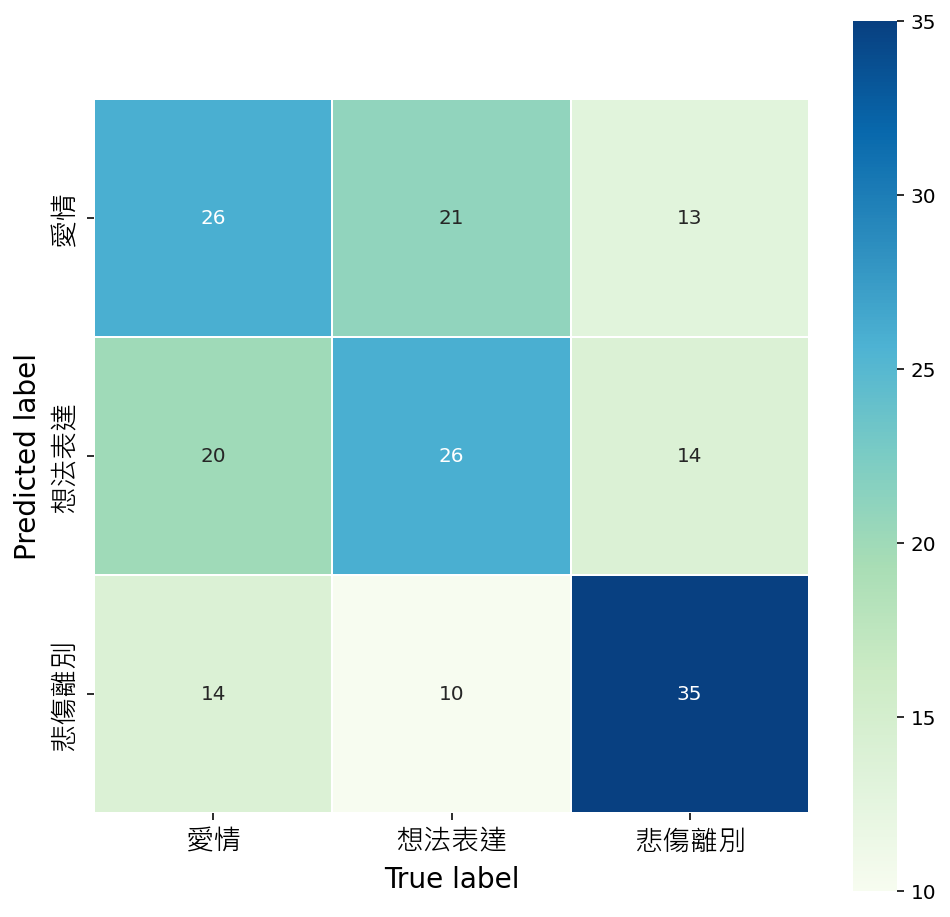

In [28]:
## confusion matrix visualization
import seaborn as sns
plt.figure(figsize = (8, 8))
sns.heatmap(matrix_result, square = True, annot = True, fmt = 'd', linewidths = 1, cmap = "GnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.yticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.show()

In [29]:
model_dbow.save('./models/dbow_model.bin')

## 分佈式存儲(DM)

In [30]:
model_dm = Doc2Vec(dm = 1, dm_mean = 1, window = 40, hs = 0, negative = 5, min_count = 1, alpha = 0.06, seed = 1)
model_dm.build_vocab([x for x in tqdm(train_tagged.values)])
print(model_dm.alpha)

100%|█████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 456361.78it/s]


0.06


In [31]:
%%time
for epoch in range(10):
    model_dm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs = 1)
    model_dm.alpha -= 0.001
    model_dm.min_alpha = model_dm.alpha

100%|█████████████████████████████████████████████████████████████████████████████| 713/713 [00:00<00:00, 404509.50it/s]


CPU times: user 4.38 s, sys: 125 ms, total: 4.5 s
Wall time: 6.21 s


In [32]:
y_train, x_train = vec_for_learning(model_dm, train_tagged)
y_test, x_test = vec_for_learning(model_dm, test_tagged)
 
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
 
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.441340782122905
Testing F1 score: 0.403665416100089


/home/vivian/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [33]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names = categories))
matrix_result = metrics.confusion_matrix(y_test, y_pred)


              precision    recall  f1-score   support

          愛情       0.55      0.30      0.39        60
        想法表達       0.43      0.20      0.27        60
        悲傷離別       0.42      0.83      0.55        59

    accuracy                           0.44       179
   macro avg       0.46      0.44      0.40       179
weighted avg       0.46      0.44      0.40       179



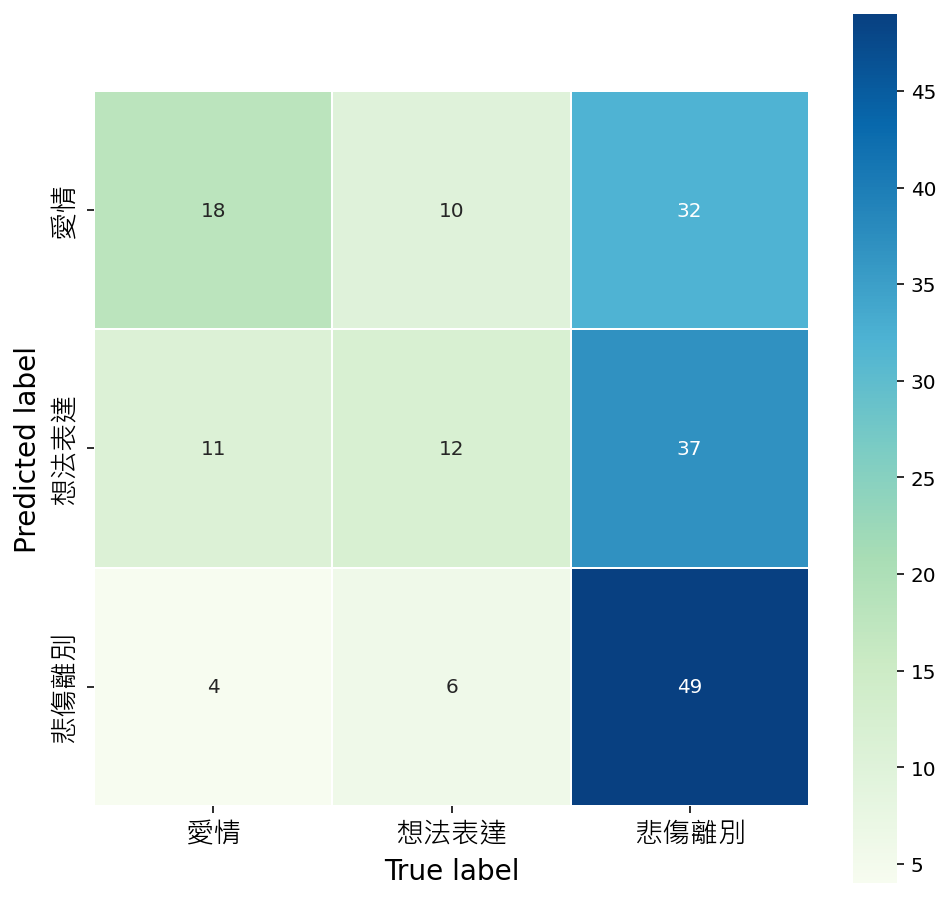

In [34]:
## confusion matrix visualization
import seaborn as sns
plt.figure(figsize = (8, 8))
sns.heatmap(matrix_result, square = True, annot = True, fmt = 'd', linewidths = 1, cmap = "GnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.yticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.show()

In [35]:
model_dm.save('./models/dm_model.bin')

## 合成DBOW & DM

In [36]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
model_concat = ConcatenatedDoc2Vec([model_dbow, model_dm])

In [37]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs = 50)) for doc in sents])
    return targets, regressors

In [38]:
y_train, x_train = get_vectors(model_concat, train_tagged)
y_test, x_test = get_vectors(model_concat, test_tagged)

KeyboardInterrupt: 

In [ ]:
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
 
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names = categories))
matrix_result = metrics.confusion_matrix(y_test, y_pred)


In [ ]:
## confusion matrix visualization
import seaborn as sns
plt.figure(figsize = (8, 8))
sns.heatmap(matrix_result, square = True, annot = True, fmt = 'd', linewidths = 1, cmap = "GnBu")
plt.xlabel('True label', size = 14)
plt.ylabel('Predicted label', size = 14)
plt.xticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.yticks(np.arange(len(categories)) + 0.5, categories, fontproperties = fonts)
plt.show()